In [1]:
%config IPCompleter.greedy=True


In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import numpy as np
import json
import seaborn as sns
import folium
import os
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText

Lets have a look at the model grid data contained in the Area Peril dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [3]:
area_peril_dictionary = pd.read_csv("../keys_data/PiWind/areaperil_dict.csv")
area_peril_dictionary.head()

,PERIL_ID,COVERAGE_TYPE,LON1,LAT1,LON2,LAT2,LON3,LAT3,LON4,LAT4,AREA_PERIL_ID
0,WSS,1,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,101
1,WSS,3,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,101
2,WTC,3,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,1
3,WTC,1,-0.917651,52.733993,-0.917651,52.740060,-0.911585,52.733993,-0.911585,52.740060,1
4,WSS,1,-0.917651,52.740060,-0.917651,52.746126,-0.911585,52.740060,-0.911585,52.746126,111


Lets plot the area peril cells on a map of the UK. For this model, the area perils are a simple uniform grid in a square.

In [4]:
m = folium.Map(location=[	52.737027, -0.914618], zoom_start=11, tiles='cartodbpositron')
area_peril_dictionary['lat']=area_peril_dictionary['LAT1']
area_peril_dictionary['lon']=area_peril_dictionary['LON1']
num_cells = area_peril_dictionary.lat.count()
num_cells_per_side = math.sqrt(num_cells)
cell_size_lat = (max(area_peril_dictionary.lat) - min(area_peril_dictionary.lat)) / (num_cells_per_side - 1)
cell_size_lon = (max(area_peril_dictionary.lon) - min(area_peril_dictionary.lon)) / (num_cells_per_side - 1)
for i, row in area_peril_dictionary.iterrows():
    geometry = [Polygon([
        (row.lon, row.lat),
        (row.lon, row.lat + cell_size_lat),
        (row.lon + cell_size_lon, row.lat + cell_size_lat),
        (row.lon + cell_size_lon, row.lat)])]        
    crs = 'epsg:4326'
    d = {'Description': ['All']}
    df = pd.DataFrame(data=d)
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    folium.GeoJson(gdf).add_to(m)
    
m.save("piwind_extent_map.html")

In [5]:
%%HTML
<iframe width="100%" height=350 src="piwind_extent_map.html"></iframe>

Lets have a look at the data contained in the Intensity Bin dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [6]:
intensity_bin_dictionary = pd.read_csv("../model_data/PiWind/intensity_bin_dict.csv")
intensity_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,62.5,67.5,65.0,1202
1,2,67.5,72.5,70.0,1202
2,3,72.5,77.5,75.0,1202
3,4,77.5,82.5,80.0,1202
4,5,82.5,87.5,85.0,1202


Lets have a look at the data contained in the footprint file. 

In [7]:
footprints = pd.read_csv("../model_data/PiWind/footprint.csv")
footprints.head()

,event_id,areaperil_id,intensity_bin_id,probability
0,1,3,1,1.0
1,1,4,2,1.0
2,1,5,2,1.0
3,1,6,3,1.0
4,1,7,3,1.0


Lets visualize the first 5 event footprints.

<ipython-input-8-b848c9212b59>:46: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid[0].cax.colorbar(im)
/home/macab/oasistest/oasis_env/oasis_env/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


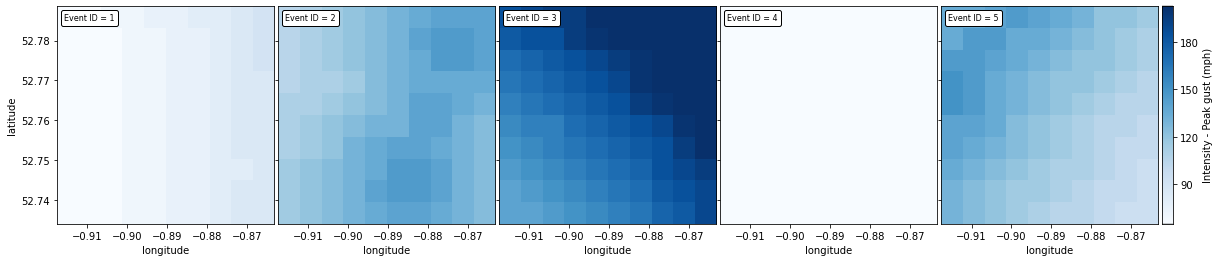

In [8]:
area_peril_dictionary['gridcell'] = area_peril_dictionary['AREA_PERIL_ID'].apply(
    lambda ap: str(int((ap-1)/10)+1)+"-"+str(ap-(int((ap-1)/10))*10))

footprints_with_hazard = footprints.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    area_peril_dictionary, how='inner', 
    left_on='areaperil_id', right_on='AREA_PERIL_ID')

footprints_with_hazard = footprints_with_hazard[footprints_with_hazard['PERIL_ID']=='WTC']
footprints_with_hazard = footprints_with_hazard[footprints_with_hazard['COVERAGE_TYPE']==1]

fig = plt.figure(figsize=(20,10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 5),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = min(footprints_with_hazard.interpolation)
vmax = max(footprints_with_hazard.interpolation)
for idx, ax in enumerate(grid):
    a = np.zeros([10, 10])
    for __, row in footprints_with_hazard[footprints_with_hazard.event_id == idx+1].iterrows():
        i, j = row.gridcell.split('-')
        a[10-int(i), int(j)-1] = row.interpolation
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(area_peril_dictionary.lon), max(area_peril_dictionary.lon), 
                       min(area_peril_dictionary.lat), max(area_peril_dictionary.lat)))
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    at = AnchoredText(
        "Event ID = {}".format(idx + 1),
        prop=dict(size=8),
        frameon=True,
        loc=2,
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Intensity - Peak gust (mph)")

plt.show()

Lets have a look at the data contained in the Damage Bin dictionary file. 
Note that the dictionary is required for model execution.

In [9]:
damage_bin_dictionary = pd.read_csv("../model_data/PiWind/damage_bin_dict.csv")
damage_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.0,0.0,0.00,1203
1,2,0.0,0.1,0.05,1200
2,3,0.1,0.2,0.15,1202
3,4,0.2,0.3,0.25,1202
4,5,0.3,0.4,0.35,1202


Lets have a look at the data contained in the Vulnerability file. 

In [10]:
vulnerabilities = pd.read_csv("../model_data/PiWind/vulnerability.csv")
vulnerabilities.head()

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
0,1,1,1,0.654
1,1,1,2,0.146
2,1,1,3,0.060
3,1,1,4,0.140
4,1,2,1,0.654


The model has seperate vulnerability curves for Residential, Commerical and Industrial occupancies. 
Lets visualise these curves.

<ipython-input-11-ca8b331eedfc>:42: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid[0].cax.colorbar(im)


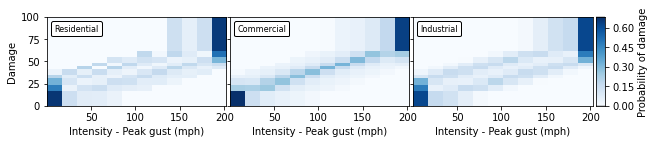

In [11]:
vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

fig = plt.figure(figsize=(10,20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = 0.0
vmax = max(vulnerabilities_with_hazard_and_damage.probability)
labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.probability
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")

plt.show()

To run the model we need some test exposure data. Lets have a look at an example Location and Account file. 

In [12]:
test_locations = pd.read_csv('../tests/inputs/SourceLocOEDPiWind.csv')
test_locations.head()

,PortNumber,AccNumber,LocNumber,LocName,LocGroup,CorrelationGroup,IsPrimary,IsTenant,BuildingID,LocInceptionDate,...,CustomFloodSOP,CustomFloodZone,MultiStoryHall,BuildingExteriorOpening,ServiceEquipmentProtection,TallOneStory,TerrainRoughness,NumberOfEmployees,Payroll,PortNumber.1
0,1,A11111,100030534294,NaN,NaN,NaN,NaN,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,A11111,100030534295,NaN,NaN,NaN,NaN,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1,A11111,100030534296,NaN,NaN,NaN,NaN,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,A11111,100030534297,NaN,NaN,NaN,NaN,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1,A11111,100030534298,NaN,NaN,NaN,NaN,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [13]:
test_accounts = pd.read_csv('../tests/inputs/SourceAccOEDPiWind.csv')
test_accounts.head()

,PortNumber,PortName,PortNotes,AccNumber,AccName,AccGroup,AccStatus,ExpiringAccNumber,CedantName,AccCurrency,...,CondLimit3Contents,CondLimitCode4BI,CondLimitType4BI,CondLimit4BI,CondLimitCode5PD,CondLimitType5PD,CondLimit5PD,CondLimitCode6All,CondLimitType6All,CondLimit6All
0,1,0,0,A11111,0,0,0,0,0,GBP,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,A11111,0,0,0,0,0,GBP,...,0,0,0,0,0,0,0,0,0,0


To run the model, we also need to define some analysis settings. Lets have a look at an example settings file.

In [14]:
with open('../analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "analysis_tag": "base_example",
 "source_tag": "MDK",
 "model_version_id": "PiWind",
 "module_supplier_id": "OasisLMF",
 "number_of_samples": 10,
 "gul_threshold": 0,
 "gul_output": true,
 "model_settings": {
  "event_set": "p",
  "event_occurrence_id": "lt"
 },
 "gul_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ],
 "il_output": true,
 "il_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ],
 "ri_output": true,
 "ri_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ]
}


We can now run the model using the Oasis MDK.

In [15]:
! rm -rf /tmp/analysis_test
! oasislmf model run -C ../oasislmf.json -r /tmp/analysis_test


Processing arguments - RunModel
RUNNING: oasislmf.manager.interface
  0%|                                                     | 0/2 [00:00<?, ?it/s]
Processing arguments - Creating Oasis Files

Generating Oasis files (GUL=True, IL=True, RIL=True)
RUNNING: oasislmf.lookup.rtree.get_vulnerabilities
Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.

Keys successful: /tmp/analysis_test/input/keys.csv generated with 40 items
Keys errors: /tmp/analysis_test/input/keys-errors.csv generated with 0 items
RUNNING: oasislmf.preparation.gul_inputs.get_gul_input_items
RUNNING: oasislmf.preparation.summaries.write_exposure_summary
RUNNING: oasislmf.preparation.summaries.get_exposure_totals
RUNNING: oasislmf.preparation.summaries.get_exposure_summary_all
RUNNING: oasislmf.preparation.summaries.get_exposure_summary_by_status
RUNNING: oasislmf.preparation.summaries.get_exposure_summary_by_status
RUNNING: oasislmf.preparati

Lets visualize the output of our analysis.

<ipython-input-16-fab7b53d4adf>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


Text(0, 0.5, 'Loss')

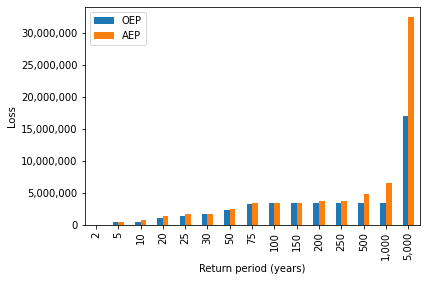

In [16]:
analysis_directory = "/tmp/analysis_test"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_aep = gul_aep[gul_aep.type == 1]
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
gul_oep = gul_oep[gul_oep.type == 1]
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
fig, ax = plt.subplots()
eps.plot(ax=ax, kind='bar', x='return_period', y=["loss_oep", "loss_aep"])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in eps.return_period])
plt.legend(('OEP', 'AEP'))
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Loss")